In [1]:
from keras.models import Sequential
from keras.layers import Dense, Dropout,Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.callbacks import TensorBoard

In [2]:
tensorboard = TensorBoard(log_dir='./logs/run1', histogram_freq=1,
    write_graph=True, write_images=False)  

In [3]:
from keras.datasets import cifar10
import matplotlib.pyplot as plt
 
(train_X,train_Y),(test_X,test_Y)=cifar10.load_data()

print("train_X",len(train_X))
print("test_X",len(test_X))
print("train_Y",len(train_Y))
print("test_Y",len(test_Y))

train_X = train_X[:7500]
train_Y = train_Y[:7500]


test_X = test_X[:500]
test_Y = test_Y[:500]

train_X 50000
test_X 10000
train_Y 50000
test_Y 10000


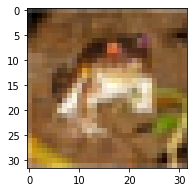

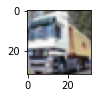

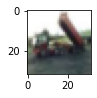

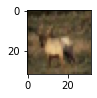

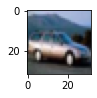

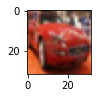

In [4]:
n=6
plt.figure(figsize=(20,10))
for i in range(n):
    plt.subplot(330+1+i)
    plt.imshow(train_X[i])
    plt.show()

In [5]:
train_x=train_X.astype('float32')
test_X=test_X.astype('float32')
 
train_X=train_X/255.0
test_X=test_X/255.0

In [6]:
print(train_Y[1])
print(len(train_Y[1]))
train_Y=np_utils.to_categorical(train_Y)
test_Y=np_utils.to_categorical(test_Y)
 
num_classes=test_Y.shape[1]
print("Num_classes:\t",num_classes)

[9]
1
Num_classes:	 10


In [7]:
model = Sequential()
model.add(Conv2D(32,(3,3),input_shape=(32,32,3),padding='same',activation='relu',kernel_constraint=maxnorm(3)))
    
model.add(Dropout(0.2))
model.add(Conv2D(32,(3,3),activation='relu',padding='same',kernel_constraint=maxnorm(3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(512,activation='relu',kernel_constraint=maxnorm(3)))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

In [8]:
sgd = SGD(lr=0.01,momentum=0.9,decay=(0.01/25),nesterov=False)
model.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])
  
  

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               4194816   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0

In [10]:
#save it in your callback list
callbacks_list = [tensorboard]

model.fit(train_X,train_Y, callbacks=callbacks_list,
    validation_data=(test_X,test_Y),
    epochs=10,batch_size=32)

Epoch 1/10
  1/235 [..............................] - ETA: 0s - loss: 2.3787 - accuracy: 0.0938WARNING:tensorflow:From /home/hpuma/.local/lib/python3.8/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
235/235 [==============================] - 8s 34ms/step - loss: 2.0837 - accuracy: 0.2373 - val_loss: 1.9700 - val_accuracy: 0.2660
Epoch 2/10
235/235 [==============================] - 8s 33ms/step - loss: 1.8276 - accuracy: 0.3523 - val_loss: 1.7034 - val_accuracy: 0.3740
Epoch 3/10
235/235 [==============================] - 8s 33ms/step - loss: 1.6867 - accuracy: 0.3872 - val_loss: 1.6450 - val_accuracy: 0.4220
Epoch 4/10
235/235 [==============================] - 8s 33ms/step - loss: 1.5388 - accuracy: 0.4377 - val_loss: 1.5154 - val_accuracy: 0.4420
Epoch 5/10
235/235 [==============================] - 8s 3

In [11]:
_,acc=model.evaluate(test_X,test_Y)
print(acc*100)

16/16 [==============================] - 0s 5ms/step - loss: 1.3018 - accuracy: 0.5240
52.399998903274536


In [12]:
model.save("model1_cifar_10epoch.h5")

def get_embedding(model, face):
    # scale pixel values
    face = face.astype('float32')
    # standardization
    mean, std = face.mean(), face.std()
    face = (face-mean)/std
    # transfer face into one sample (3 dimension to 4 dimension)
    sample = np.expand_dims(face, axis=0)
    # make prediction to get embedding
    yhat = model.predict(sample)
    return yhat[0]
    
# convert each face in the train set into embedding
emdTrainX = list()
for face in train_X:
    emd = get_embedding(model, face)
    emdTrainX.append(emd)
    
emdTrainX = np.asarray(emdTrainX)
print(emdTrainX.shape)

# convert each face in the test set into embedding
emdTestX = list()
for face in test_X:
    emd = get_embedding(model, face)
    emdTestX.append(emd)
emdTestX = np.asarray(emdTestX)
print(emdTestX.shape)

# save arrays to one file in compressed format
np.savez_compressed('5-celebrity-faces-embeddings.npz', emdTrainX, train_Y, emdTestX, test_Y)

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC

print("Dataset: train=%d, test=%d" % (emdTrainX.shape[0], emdTestX.shape[0]))
# normalize input vectors
in_encoder = Normalizer()
emdTrainX_norm = in_encoder.transform(emdTrainX)
emdTestX_norm = in_encoder.transform(emdTestX)
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(train_Y[0])
trainy_enc = out_encoder.transform(train_Y[0])
testy_enc = out_encoder.transform(test_Y[0])

print(emdTrainX_norm.shape)
print(emdTestX.shape)

print(len(emdTrainX_norm))
print(len(trainy_enc))

# fit model
model = SVC(kernel='linear', probability=True)
model.fit(emdTrainX_norm, trainy_enc)
# predict
yhat_train = model.predict(emdTrainX_norm)
yhat_test = model.predict(emdTestX_norm)
# score
score_train = accuracy_score(trainy_enc, yhat_train)
score_test = accuracy_score(testy_enc, yhat_test)
# summarize
print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))

print(len(emdTrainX_norm))
print(len(trainy_enc))

# fit model
model = SVC(kernel='linear', probability=True)
model.fit(emdTrainX_norm, trainy_enc)
# predict
yhat_train = model.predict(emdTrainX_norm)
yhat_test = model.predict(emdTestX_norm)
# score
score_train = accuracy_score(trainy_enc, yhat_train)
score_test = accuracy_score(testy_enc, yhat_test)
# summarize
print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))